In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2023-01-05 13:37:33.175663: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-05 13:37:46.695028: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-01-05 13:37:46.706982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-05 13:37:46.707017: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-05 13:37:46.709577: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-01-05 13:37:46.712264: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# One dimensional functions

> Here, I try to model $y=f(x)$ with a neural net by using both $y$ and $y''=f''(x)$.

In [2]:
def Gaussian(x, loc=0.0, scale=1.0):
    return np.exp(-(x-loc)**2/(2*scale**2))

data_1d_x = np.linspace(-4, 4, 512)[:,np.newaxis].astype(np.float32)
data_1d_y_gaussian = Gaussian(data_1d_x, 1.0)


ds_gaussian = TINN_Dataset(tf.float32, 
                           np.concatenate([data_1d_x, data_1d_y_gaussian], axis=1))

In [3]:
@tf.function
def derivatives(pinn, x):
    y = pinn.net(x)
    p1, p2 = pinn.gradients(x, y)
    return y, p1, p2

In [54]:
layers = [1, 10, 1]
pinn = tu.NN(layers, 
             lb= np.min(data_1d_x),
             ub= np.max(data_1d_x),
             dtype=tf.float32)

# Initial output of an untrained network

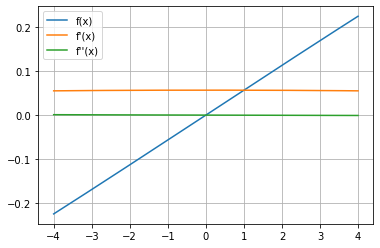

In [55]:
y, y_der_1, y_der_2 = derivatives(pinn, data_1d_x)
plt.plot(data_1d_x, y.numpy(), label="f(x)")
plt.plot(data_1d_x, y_der_1[0].numpy(), label="f'(x)")
plt.plot(data_1d_x, y_der_2[0].numpy(), label="f''(x)")
plt.legend()
plt.grid()
plt.show()

# Train the model

In [56]:
loss = Observation_Loss(layers, residual_ret_names=("f(x)",))
model = tu.TINN(pinn, [loss], L2(), optimizer=keras.optimizers.Adam(learning_rate=1e-4))
results = model.train(100000+1, 256, ds_gaussian, print_interval=5000,stop_threshold=5e-5)


Start of epoch 0
total loss: 0.40576, total regularised loss: 0.40576
Observation_Loss -> 
(1)  f(x): 0.20288 
(1) lambdas : 1.00000 
Time taken: 0.80s

Start of epoch 5000
total loss: 0.17287, total regularised loss: 0.17287
Observation_Loss -> 
(1)  f(x): 0.08643 
(1) lambdas : 1.00000 
Time taken: 47.39s

Start of epoch 10000
total loss: 0.04695, total regularised loss: 0.04695
Observation_Loss -> 
(1)  f(x): 0.02348 
(1) lambdas : 1.00000 
Time taken: 46.40s

Start of epoch 15000
total loss: 0.01298, total regularised loss: 0.01298
Observation_Loss -> 
(1)  f(x): 0.00649 
(1) lambdas : 1.00000 
Time taken: 47.57s

Start of epoch 20000
total loss: 0.00210, total regularised loss: 0.00210
Observation_Loss -> 
(1)  f(x): 0.00105 
(1) lambdas : 1.00000 
Time taken: 48.54s

Start of epoch 25000
total loss: 0.00041, total regularised loss: 0.00041
Observation_Loss -> 
(1)  f(x): 0.00021 
(1) lambdas : 1.00000 
Time taken: 48.28s
############################################
#            

# After training

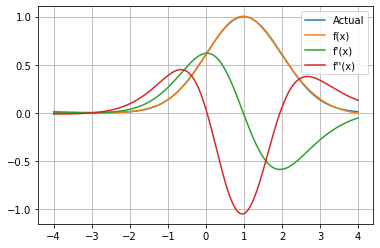

In [57]:
y, y_der_1, y_der_2 = derivatives(pinn, data_1d_x)
plt.plot(data_1d_x, data_1d_y_gaussian , label="Actual")
plt.plot(data_1d_x, y.numpy(), label="f(x)")
plt.plot(data_1d_x, y_der_1[0].numpy(), label="f'(x)")
plt.plot(data_1d_x, y_der_2[0].numpy(), label="f''(x)")
plt.legend()
plt.grid()
plt.show()

# Two-dimensional data

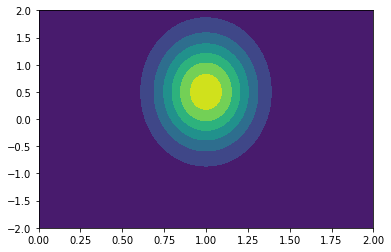

In [4]:
def Gaussian_2d(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return np.exp(-(x-locx)**2/(2*scalex**2)-(y-locy)**2/(2*scaley**2))

def Gaussian_2d_df_dx(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(x-locx)/(scalex**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_df_dy(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(y-locy)/(scaley**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_d2f_dx2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scalex**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley)
            -((x-locx)/(scalex**2))*Gaussian_2d_df_dx(x, y, locx, locy, scalex, scaley))

def Gaussian_2d_d2f_dy2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scaley**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley) 
            -((y-locy)/(scaley**2))*Gaussian_2d_df_dy(x, y, locx, locy, scalex, scaley))


data_2d_x = np.linspace(0, 2, 128)[:,np.newaxis].astype(np.float32)
data_2d_y = np.linspace(-2, 2, 128)[:,np.newaxis].astype(np.float32)
X,Y = np.meshgrid(data_2d_x, data_2d_y,indexing='ij')
data_2d_z_gaussian = Gaussian_2d(X, Y, 1.0, 0.5, .2, .7)
data_input = np.concatenate([X.flatten()[:,np.newaxis],
                             Y.flatten()[:,np.newaxis]], 
                              axis=1)

ds_gaussian_2d = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], 
                              axis=1))

def plot(X, Y, Z, title=""):
    plt.title(title)
    plt.contourf(X, Y, Z)    
    
plot(X, Y, data_2d_z_gaussian)
plt.show()

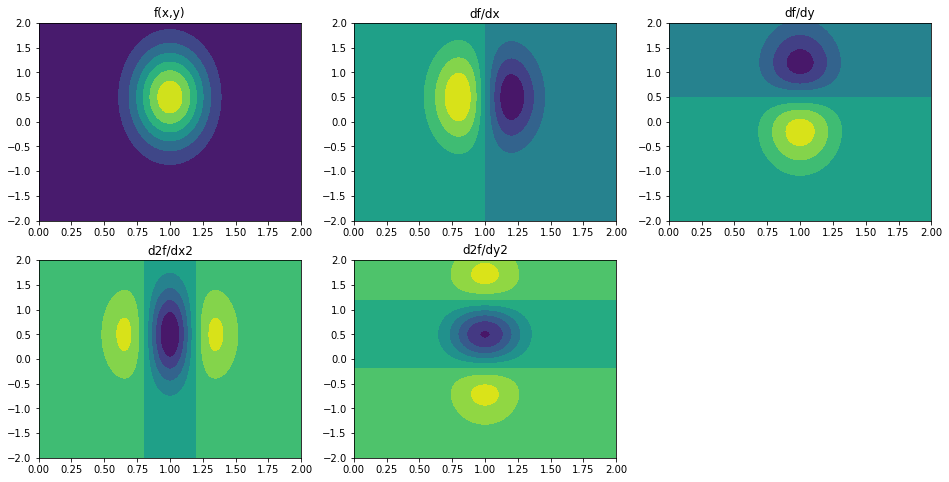

In [5]:
_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, data_2d_z_gaussian, "f(x,y)")
plt.subplot(232)
plot(X, Y, Gaussian_2d_df_dx(X, Y, 1.0, 0.5, .2, .7), "df/dx")
plt.subplot(233)
plot(X, Y, Gaussian_2d_df_dy(X, Y, 1.0, 0.5, .2, .7), "df/dy")
plt.subplot(234)
plot(X, Y, Gaussian_2d_d2f_dx2(X, Y, 1.0, 0.5, .2, .7), "d2f/dx2")
plt.subplot(235)
plot(X, Y, Gaussian_2d_d2f_dy2(X, Y, 1.0, 0.5, .2, .7), "d2f/dy2")
plt.show()

In [88]:
layers2 = [2, 10, 1]
pinn2 = tu.NN(layers2, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

# Initial output of an untrained network

In [6]:
def to_2d(x):
    return x.reshape((data_2d_x.shape[0], data_2d_x.shape[0]))

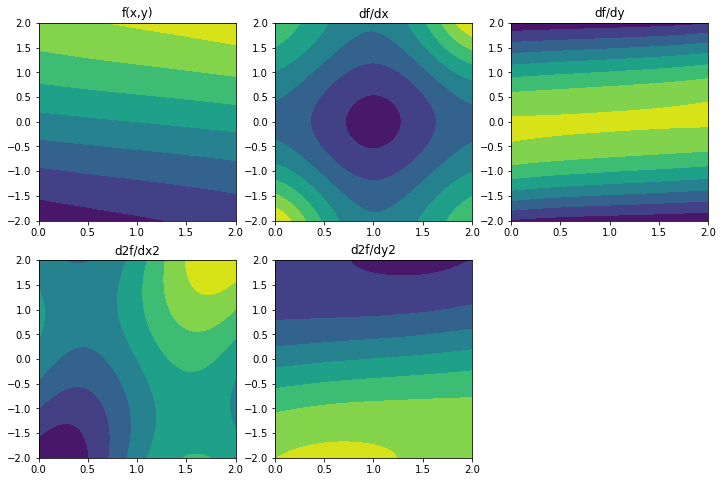

In [105]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(12,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), "f(x,y)")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), "df/dx")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), "df/dy")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), "d2f/dx2")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), "d2f/dy2")
plt.show()

# Train the model

In [108]:
loss2 = Observation_Loss(layers2, residual_ret_names=("f(x,y)",))
model2 = tu.TINN(pinn2, [loss2], L2(), optimizer=keras.optimizers.Adam(learning_rate=1e-4))
results2 = model2.train(100000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=5e-5)


Start of epoch 0
total loss: 0.29637, total regularised loss: 0.29637
Observation_Loss -> 
(1)  f(x,y): 0.07409 
(1) lambdas : 1.00000 
Time taken: 1.65s

Start of epoch 5000
total loss: 0.14536, total regularised loss: 0.14536
Observation_Loss -> 
(1)  f(x,y): 0.03634 
(1) lambdas : 1.00000 
Time taken: 133.72s

Start of epoch 10000
total loss: 0.10306, total regularised loss: 0.10306
Observation_Loss -> 
(1)  f(x,y): 0.02576 
(1) lambdas : 1.00000 
Time taken: 130.59s

Start of epoch 15000
total loss: 0.06219, total regularised loss: 0.06219
Observation_Loss -> 
(1)  f(x,y): 0.01555 
(1) lambdas : 1.00000 
Time taken: 130.46s

Start of epoch 20000
total loss: 0.04383, total regularised loss: 0.04383
Observation_Loss -> 
(1)  f(x,y): 0.01096 
(1) lambdas : 1.00000 
Time taken: 131.90s

Start of epoch 25000
total loss: 0.03412, total regularised loss: 0.03412
Observation_Loss -> 
(1)  f(x,y): 0.00853 
(1) lambdas : 1.00000 
Time taken: 129.71s

Start of epoch 30000
total loss: 0.02728

In [110]:
results3 = model2.train(50000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=5e-5, regularise=False)


Start of epoch 0
total loss: 0.00665, total regularised loss: 0.00665
Observation_Loss -> 
(1)  f(x,y): 0.00166 
(1) lambdas : 1.00000 
Time taken: 1.29s

Start of epoch 5000
total loss: 0.00641, total regularised loss: 0.00641
Observation_Loss -> 
(1)  f(x,y): 0.00160 
(1) lambdas : 1.00000 
Time taken: 117.39s

Start of epoch 10000
total loss: 0.00613, total regularised loss: 0.00613
Observation_Loss -> 
(1)  f(x,y): 0.00153 
(1) lambdas : 1.00000 
Time taken: 118.39s

Start of epoch 15000
total loss: 0.00581, total regularised loss: 0.00581
Observation_Loss -> 
(1)  f(x,y): 0.00145 
(1) lambdas : 1.00000 
Time taken: 118.96s

Start of epoch 20000
total loss: 0.00531, total regularised loss: 0.00531
Observation_Loss -> 
(1)  f(x,y): 0.00133 
(1) lambdas : 1.00000 
Time taken: 118.24s

Start of epoch 25000
total loss: 0.00457, total regularised loss: 0.00457
Observation_Loss -> 
(1)  f(x,y): 0.00114 
(1) lambdas : 1.00000 
Time taken: 118.05s

Start of epoch 30000
total loss: 0.00382

In [113]:
results4 = model2.train(50000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=5e-5, 
                        regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.00264, total regularised loss: 0.00264
Observation_Loss -> 
(1)  f(x,y): 0.00066 
Time taken: 1.17s

Start of epoch 5000
total loss: 0.00249, total regularised loss: 0.00249
Observation_Loss -> 
(1)  f(x,y): 0.00062 
Time taken: 117.40s

Start of epoch 10000
total loss: 0.00231, total regularised loss: 0.00231
Observation_Loss -> 
(1)  f(x,y): 0.00058 
Time taken: 116.15s

Start of epoch 15000
total loss: 0.00207, total regularised loss: 0.00207
Observation_Loss -> 
(1)  f(x,y): 0.00052 
Time taken: 115.92s

Start of epoch 20000
total loss: 0.00185, total regularised loss: 0.00185
Observation_Loss -> 
(1)  f(x,y): 0.00046 
Time taken: 115.59s

Start of epoch 25000
total loss: 0.00168, total regularised loss: 0.00168
Observation_Loss -> 
(1)  f(x,y): 0.00042 
Time taken: 116.37s

Start of epoch 30000
total loss: 0.00155, total regularised loss: 0.00155
Observation_Loss -> 
(1)  f(x,y): 0.00039 
Time taken: 116.20s

Start of epoch 35000
total loss: 0.00146

In [118]:
model2.optimizer.lr.assign(5e-5)
results4 = model2.train(50000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=5e-5, 
                        regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.00125, total regularised loss: 0.00125
Observation_Loss -> 
(1)  f(x,y): 0.00031 
Time taken: 1.07s

Start of epoch 5000
total loss: 0.00122, total regularised loss: 0.00122
Observation_Loss -> 
(1)  f(x,y): 0.00031 
Time taken: 114.03s

Start of epoch 10000
total loss: 0.00119, total regularised loss: 0.00119
Observation_Loss -> 
(1)  f(x,y): 0.00030 
Time taken: 111.79s

Start of epoch 15000
total loss: 0.00115, total regularised loss: 0.00115
Observation_Loss -> 
(1)  f(x,y): 0.00029 
Time taken: 115.22s

Start of epoch 20000
total loss: 0.00110, total regularised loss: 0.00110
Observation_Loss -> 
(1)  f(x,y): 0.00028 
Time taken: 116.46s

Start of epoch 25000
total loss: 0.00104, total regularised loss: 0.00104
Observation_Loss -> 
(1)  f(x,y): 0.00026 
Time taken: 114.95s

Start of epoch 30000
total loss: 0.00096, total regularised loss: 0.00096
Observation_Loss -> 
(1)  f(x,y): 0.00024 
Time taken: 119.75s

Start of epoch 35000
total loss: 0.00089

# After training

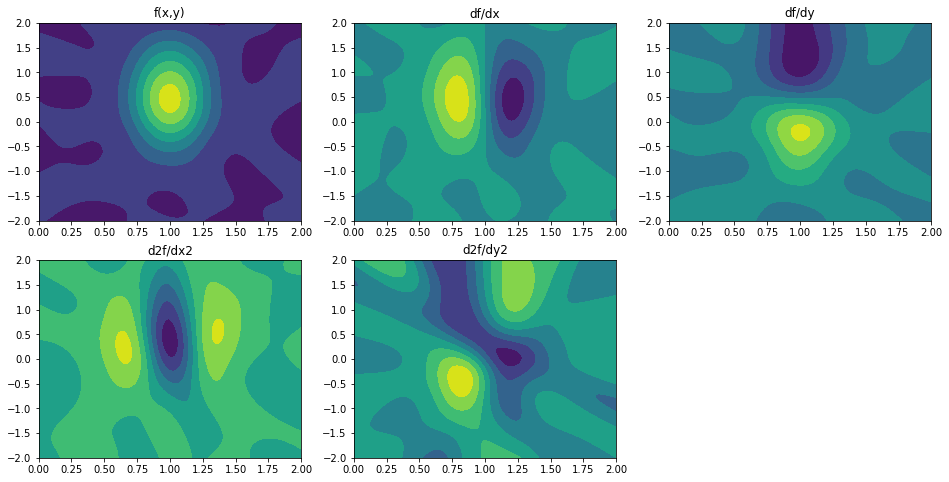

In [119]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), "f(x,y)")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), "df/dx")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), "df/dy")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), "d2f/dx2")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), "d2f/dy2")
plt.show()

# Second 2D model with higher capacity

In [122]:
layers3 = [2, 128, 1]
pinn3 = tu.NN(layers3, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

In [123]:
loss3 = Observation_Loss(layers3, residual_ret_names=("f(x,y)",))
model3 = tu.TINN(pinn3, [loss3], L2(), optimizer=keras.optimizers.Adam(learning_rate=1e-4))
results5 = model3.train(500000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=5e-5,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.24406, total regularised loss: 0.24406
Observation_Loss -> 
(1)  f(x,y): 0.06102 
Time taken: 1.48s

Start of epoch 5000
total loss: 0.16184, total regularised loss: 0.16184
Observation_Loss -> 
(1)  f(x,y): 0.04046 
Time taken: 117.07s

Start of epoch 10000
total loss: 0.15838, total regularised loss: 0.15838
Observation_Loss -> 
(1)  f(x,y): 0.03959 
Time taken: 117.47s

Start of epoch 15000
total loss: 0.14202, total regularised loss: 0.14202
Observation_Loss -> 
(1)  f(x,y): 0.03551 
Time taken: 119.94s

Start of epoch 20000
total loss: 0.09942, total regularised loss: 0.09942
Observation_Loss -> 
(1)  f(x,y): 0.02486 
Time taken: 118.65s

Start of epoch 25000
total loss: 0.06740, total regularised loss: 0.06740
Observation_Loss -> 
(1)  f(x,y): 0.01685 
Time taken: 116.47s

Start of epoch 30000
total loss: 0.05285, total regularised loss: 0.05285
Observation_Loss -> 
(1)  f(x,y): 0.01321 
Time taken: 115.54s

Start of epoch 35000
total loss: 0.04005


Start of epoch 300000
total loss: 0.00007, total regularised loss: 0.00007
Observation_Loss -> 
(1)  f(x,y): 0.00002 
Time taken: 122.82s

Start of epoch 305000
total loss: 0.00007, total regularised loss: 0.00007
Observation_Loss -> 
(1)  f(x,y): 0.00002 
Time taken: 119.68s

Start of epoch 310000
total loss: 0.00006, total regularised loss: 0.00006
Observation_Loss -> 
(1)  f(x,y): 0.00002 
Time taken: 119.55s

Start of epoch 315000
total loss: 0.00007, total regularised loss: 0.00007
Observation_Loss -> 
(1)  f(x,y): 0.00002 
Time taken: 116.29s

Start of epoch 320000
total loss: 0.00006, total regularised loss: 0.00006
Observation_Loss -> 
(1)  f(x,y): 0.00002 
Time taken: 113.49s

Start of epoch 325000
total loss: 0.00006, total regularised loss: 0.00006
Observation_Loss -> 
(1)  f(x,y): 0.00001 
Time taken: 118.08s

Start of epoch 330000
total loss: 0.00006, total regularised loss: 0.00006
Observation_Loss -> 
(1)  f(x,y): 0.00001 
Time taken: 113.92s

Start of epoch 335000
tota

In [131]:
loss3.print_precision = ".10f"
model3.print_precision = ".10f"
model3.optimizer.lr.assign(5e-5)
results6 = model3.train(100000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=1e-6,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.0001171530, total regularised loss: 0.0001171530
Observation_Loss -> 
(1)  f(x,y): 0.0000292882 
Time taken: 0.97s

Start of epoch 5000
total loss: 0.0000488466, total regularised loss: 0.0000488467
Observation_Loss -> 
(1)  f(x,y): 0.0000122117 
Time taken: 120.61s

Start of epoch 10000
total loss: 0.0000488163, total regularised loss: 0.0000488163
Observation_Loss -> 
(1)  f(x,y): 0.0000122041 
Time taken: 115.84s

Start of epoch 15000
total loss: 0.0000502060, total regularised loss: 0.0000502059
Observation_Loss -> 
(1)  f(x,y): 0.0000125515 
Time taken: 118.55s

Start of epoch 20000
total loss: 0.0000473627, total regularised loss: 0.0000473627
Observation_Loss -> 
(1)  f(x,y): 0.0000118407 
Time taken: 115.77s

Start of epoch 25000
total loss: 0.0000482191, total regularised loss: 0.0000482191
Observation_Loss -> 
(1)  f(x,y): 0.0000120548 
Time taken: 118.31s

Start of epoch 30000
total loss: 0.0000471000, total regularised loss: 0.0000471000
Obse

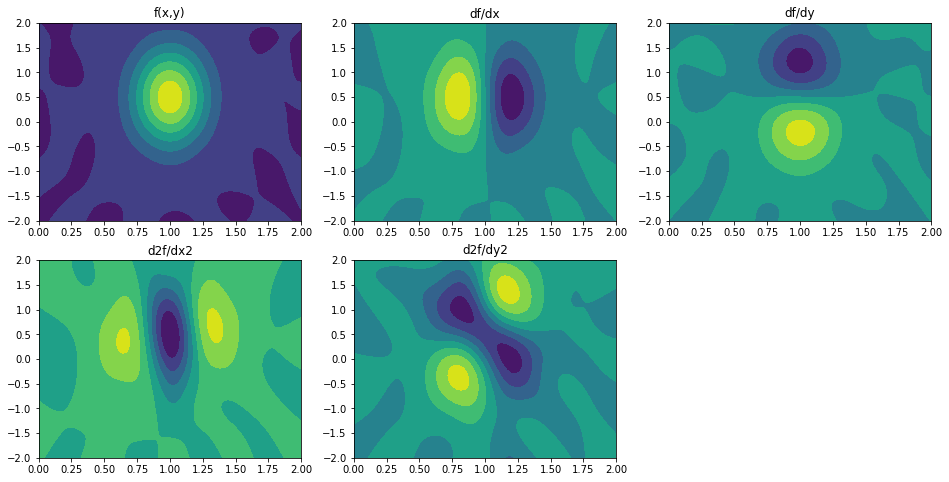

In [132]:
y, y_der_1, y_der_2 = derivatives(pinn3, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), "f(x,y)")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), "df/dx")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), "df/dy")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), "d2f/dx2")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), "d2f/dy2")
plt.show()

# Third 2D model with two hidden layers

In [133]:
layers4 = [2, 128, 128, 1]
pinn4 = tu.NN(layers4, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

In [135]:
loss4 = Observation_Loss(layers4, residual_ret_names=("f(x,y)",), print_precision = ".10f")
model4 = tu.TINN(pinn4, [loss4], L2(),
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results7 = model4.train(500000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=1e-6,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.2359610377, total regularised loss: 0.2359610498
Observation_Loss -> 
(1)  f(x,y): 0.0589902594 
Time taken: 1.74s

Start of epoch 5000
total loss: 0.0008787420, total regularised loss: 0.0008787421
Observation_Loss -> 
(1)  f(x,y): 0.0002196855 
Time taken: 122.87s

Start of epoch 10000
total loss: 0.0001305454, total regularised loss: 0.0001305454
Observation_Loss -> 
(1)  f(x,y): 0.0000326363 
Time taken: 122.83s

Start of epoch 15000
total loss: 0.0000692052, total regularised loss: 0.0000692052
Observation_Loss -> 
(1)  f(x,y): 0.0000173013 
Time taken: 123.38s

Start of epoch 20000
total loss: 0.0000477242, total regularised loss: 0.0000477242
Observation_Loss -> 
(1)  f(x,y): 0.0000119311 
Time taken: 118.73s

Start of epoch 25000
total loss: 0.0000340502, total regularised loss: 0.0000340502
Observation_Loss -> 
(1)  f(x,y): 0.0000085126 
Time taken: 124.72s

Start of epoch 30000
total loss: 0.0000261693, total regularised loss: 0.0000261693
Obse


Start of epoch 270000
total loss: 0.0000026405, total regularised loss: 0.0000026405
Observation_Loss -> 
(1)  f(x,y): 0.0000006601 
Time taken: 128.45s

Start of epoch 275000
total loss: 0.0000032578, total regularised loss: 0.0000032578
Observation_Loss -> 
(1)  f(x,y): 0.0000008144 
Time taken: 123.29s

Start of epoch 280000
total loss: 0.0000017333, total regularised loss: 0.0000017333
Observation_Loss -> 
(1)  f(x,y): 0.0000004333 
Time taken: 126.14s

Start of epoch 285000
total loss: 0.0000032079, total regularised loss: 0.0000032079
Observation_Loss -> 
(1)  f(x,y): 0.0000008020 
Time taken: 120.23s

Start of epoch 290000
total loss: 0.0000011048, total regularised loss: 0.0000011048
Observation_Loss -> 
(1)  f(x,y): 0.0000002762 
Time taken: 125.48s

Start of epoch 295000
total loss: 0.0000095085, total regularised loss: 0.0000095085
Observation_Loss -> 
(1)  f(x,y): 0.0000023771 
Time taken: 125.20s

Start of epoch 300000
total loss: 0.0000051635, total regularised loss: 0.0

In [136]:
model4.save(".", "Gaussian_2d_2_hidden")

In [8]:
model4 = tu.TINN.restore(".", "Gaussian_2d_2_hidden", ds_gaussian_2d)
pinn4 = model4.pinn

2023-01-05 13:39:31.370059: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-01-05 13:39:31.576357: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


# The model average RMSE on the training set is 0.1%.

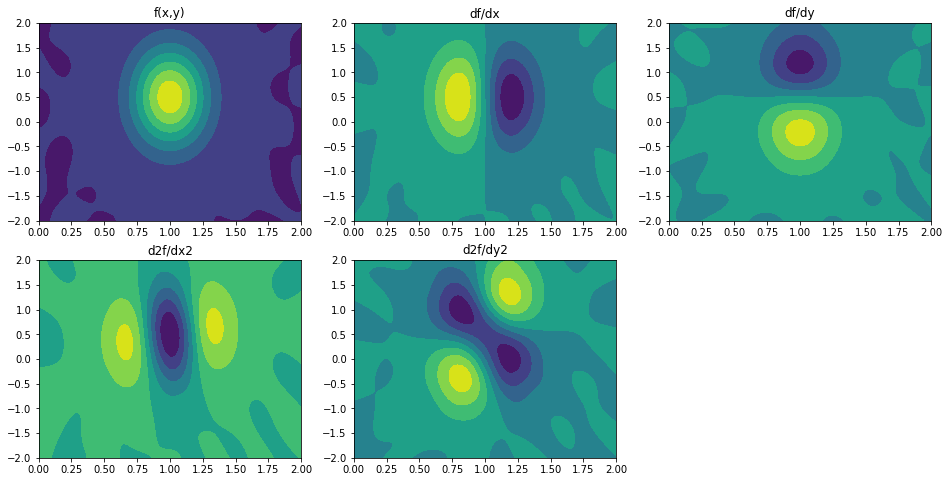

In [9]:
y, y_der_1, y_der_2 = derivatives(pinn4, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), "f(x,y)")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), "df/dx")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), "df/dy")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), "d2f/dx2")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), "d2f/dy2")
plt.show()

# Rune a test on intermidite points

In [11]:
dx = (data_2d_x[1]-data_2d_x[0])[0]/2
dy = (data_2d_y[1]-data_2d_y[0])[0]/2


test_data_input = np.concatenate([X.flatten()[:,np.newaxis] + dx,
                                  Y.flatten()[:,np.newaxis] + dy], 
                                  axis=1)

test_data_2d_z_gaussian = Gaussian_2d(X + dx, Y + dy, 1.0, 0.5, .2, .7)
test_2d_df_dx = Gaussian_2d_df_dx(X + dx, Y + dy, 1.0, 0.5, .2, .7)
test_2d_df_dy = Gaussian_2d_df_dy(X + dx, Y + dy, 1.0, 0.5, .2, .7)
test_2d_d2f_dx2 = Gaussian_2d_d2f_dx2(X + dx, Y + dy, 1.0, 0.5, .2, .7)
test_2d_d2f_dy2 = Gaussian_2d_d2f_dy2(X + dx, Y + dy, 1.0, 0.5, .2, .7)

# Clearly, second order derivatives RMSEs are large, even if the f(x) RMSE is less 0.05%.

In [14]:
y_test, y_der_1_test, y_der_2_test = derivatives(pinn4, test_data_input)

def RMSE(pred, actual):
    return np.sqrt(np.mean((pred-actual)**2))

print(f"f(x)    RMSE: {RMSE(to_2d(y_test.numpy()), test_data_2d_z_gaussian) :.5f}")
print(f"df/dx   RMSE: {RMSE(to_2d(y_der_1_test[0].numpy()[:,0]), test_2d_df_dx) :.5f}")
print(f"df/dy   RMSE: {RMSE(to_2d(y_der_1_test[0].numpy()[:,1]), test_2d_df_dy) :.5f}")
print(f"d2f/dx2 RMSE: {RMSE(to_2d(y_der_2_test[0].numpy()[:,0]), test_2d_d2f_dx2) :.5f}")
print(f"d2f/dy2 RMSE: {RMSE(to_2d(y_der_2_test[0].numpy()[:,1]), test_2d_d2f_dy2) :.5f}")

f(x)    RMSE: 0.00050
df/dx   RMSE: 0.00765
df/dy   RMSE: 0.00312
d2f/dx2 RMSE: 0.83671
d2f/dy2 RMSE: 0.82780


# Retrain model furthur

In [17]:
model4.optimizer.lr.assign(2e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2e-05>

In [18]:
results8 = model4.train(100000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=1e-8,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.0000019968, total regularised loss: 0.0000019968
Observation_Loss -> 
(1)  f(x,y): 0.0000004992 
Time taken: 1.55s

Start of epoch 5000
total loss: 0.0000009677, total regularised loss: 0.0000009677
Observation_Loss -> 
(1)  f(x,y): 0.0000002419 
Time taken: 121.48s

Start of epoch 10000
total loss: 0.0000009451, total regularised loss: 0.0000009451
Observation_Loss -> 
(1)  f(x,y): 0.0000002363 
Time taken: 124.37s

Start of epoch 15000
total loss: 0.0000009254, total regularised loss: 0.0000009254
Observation_Loss -> 
(1)  f(x,y): 0.0000002313 
Time taken: 122.79s

Start of epoch 20000
total loss: 0.0000009075, total regularised loss: 0.0000009075
Observation_Loss -> 
(1)  f(x,y): 0.0000002269 
Time taken: 124.15s

Start of epoch 25000
total loss: 0.0000010339, total regularised loss: 0.0000010339
Observation_Loss -> 
(1)  f(x,y): 0.0000002585 
Time taken: 122.68s

Start of epoch 30000
total loss: 0.0000012962, total regularised loss: 0.0000012962
Obse

In [19]:
y_test, y_der_1_test, y_der_2_test = derivatives(pinn4, test_data_input)

def RMSE(pred, actual):
    return np.sqrt(np.mean((pred-actual)**2))

print(f"f(x)    RMSE: {RMSE(to_2d(y_test.numpy()), test_data_2d_z_gaussian) :.5f}")
print(f"df/dx   RMSE: {RMSE(to_2d(y_der_1_test[0].numpy()[:,0]), test_2d_df_dx) :.5f}")
print(f"df/dy   RMSE: {RMSE(to_2d(y_der_1_test[0].numpy()[:,1]), test_2d_df_dy) :.5f}")
print(f"d2f/dx2 RMSE: {RMSE(to_2d(y_der_2_test[0].numpy()[:,0]), test_2d_d2f_dx2) :.5f}")
print(f"d2f/dy2 RMSE: {RMSE(to_2d(y_der_2_test[0].numpy()[:,1]), test_2d_d2f_dy2) :.5f}")

f(x)    RMSE: 0.00042
df/dx   RMSE: 0.00661
df/dy   RMSE: 0.00259
d2f/dx2 RMSE: 0.83419
d2f/dy2 RMSE: 0.82750


In [20]:
model4.save(".", "Gaussian_2d_2_hidden")